In [9]:
import zipfile
import pandas as pd
import os

with zipfile.ZipFile(os.path.join('tm10007_ml','ecg','ecg_data.zip'), 'r') as zip_ref:
    zip_ref.extractall('/content/tm10007_ml/ecg')

data = pd.read_csv('/content/tm10007_ml/ecg/ecg_data.csv', index_col=0)

print(f'The number of samples: {len(data.index)}')
print(f'The number of columns: {len(data.columns)}')

The number of samples: 827
The number of columns: 9001


In [20]:
# General packages
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets as ds
from sklearn import metrics
from sklearn import model_selection
from sklearn.metrics import roc_auc_score

# Classifiers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.feature_selection import RFECV, SelectKBest, SelectFdr, chi2, f_classif
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import learning_curve 

In [21]:
labels = data.iloc[:,-1]
x = data.iloc[:,:-1]

X_train, X_test, y_train, y_test = model_selection.train_test_split(x, labels, test_size=0.25, stratify=labels, random_state=42)
print(X_test.shape)
print(X_train.shape)

(207, 9000)
(620, 9000)


In [29]:
train_scores = []
test_scores = []
k_list= np.arange(100, 9000, 100)
for k in k_list:
    knn = Pipeline([('feature_selection', SelectKBest(f_classif, k=k)), ('scaler', StandardScaler()),('classifier', KNeighborsClassifier())])
    knn.fit(X_train, y_train)
    train_scores.append(roc_auc_score(y_train, knn.predict_proba(X_train)[:,1]))
    test_scores.append(roc_auc_score(y_test, knn.predict_proba(X_test)[:,1]))


parameters = {
    'classifier__n_neighbors': [1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski'], 
    'classifier__n_jobs': [-1],     
    } 

model = RandomizedSearchCV(
    estimator=knn,
    param_distributions=parameters,
    n_iter=10,
    n_jobs=-1,
    cv=5,
    scoring='roc_auc'  
)

model.fit(X_train, y_train)

print("Best estimator:", model.best_estimator_ )
print("Best Score:", model.best_score_)
print("best parameters:", model.best_params_)


Best estimator: Pipeline(steps=[('feature_selection', SelectKBest(k=8900)),
                ('scaler', StandardScaler()),
                ('classifier',
                 KNeighborsClassifier(metric='chebyshev', n_jobs=-1,
                                      n_neighbors=11))])
Best Score: 0.7033084372319095
best parameters: {'classifier__weights': 'uniform', 'classifier__n_neighbors': 11, 'classifier__n_jobs': -1, 'classifier__metric': 'chebyshev'}


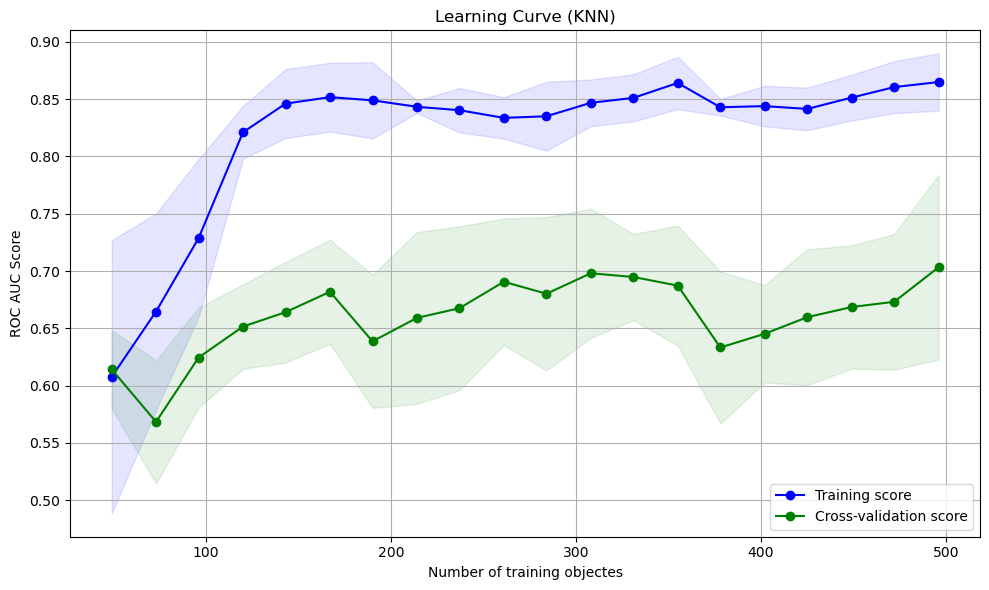

In [31]:


#Learning curve
train_sizes, train_scores, test_scores = learning_curve(
    model.best_estimator_,
    X_train,
    y_train,
    cv=5,
    scoring='roc_auc',
    train_sizes=np.linspace(0.1, 1.0, 20),
    n_jobs=-1
)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.title("Learning Curve (KNN)")
plt.xlabel("Number of training objectes")
plt.ylabel("ROC AUC Score")

plt.grid()

plt.plot(train_sizes, train_scores_mean, 'o-', label="Training score", color="blue")
plt.fill_between(train_sizes, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.1, color="blue")

plt.plot(train_sizes, test_scores_mean, 'o-', label="Cross-validation score", color="green")
plt.fill_between(train_sizes, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.1, color="green")

plt.legend(loc="best")
plt.tight_layout()
plt.show()